# Importing Modules

In [1]:
import torch
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Train And Test Sets

In [2]:
class_names=['covid','normal','viral']
main_dir='COVID-19 Radiography Database'
source_dirs=['NORMAL','Viral Pneumonia','COVID-19']

In [3]:
class covid_dataset(torch.utils.data.Dataset):
    
    def __init__(self,dir,transforms):
        # dir is a list of class names and directory path 
        def get_images(class_name):
            images=[x for x in os.listdir(dir[class_name]) if (x[-3:].lower().endswith('png'))]
            return images
        
        self.images={}
        self.class_names=['normal','covid','viral']
        
        for class_name in self.class_names:
            self.images[class_name]=get_images(class_name) # get the images of that class 
        
        self.img_dirs=dir
        self.transform=transforms
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self,index):
        
        class_name=random.choice(self.class_names)
        index=index%len(self.images[class_name])
        image_name=self.images[class_name][index]
        image_path=os.path.join(self.img_dirs[class_name],image_name)
        image=Image.open(image_path).convert('RGB')
        return self.transform(image),self.class_names.index(class_name)        

In [4]:
# directories containing images for training purposes
train_dirs={
    'viral':'./COVID-19 Radiography Database/Viral Pneumonia',
    'normal':'./COVID-19 Radiography Database/NORMAL',
    'covid':'./COVID-19 Radiography Database/COVID-19'
}

test_dirs={
    'viral':'COVID-19 Radiography Database/test/viral',
    'normal':'COVID-19 Radiography Database/test/viral',
    'covid':'COVID-19 Radiography Database/test/covid'
}

In [5]:
import torchvision

In [6]:
# transform using torchvision

train_transforms=torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_transforms=torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485,0.456,0.404],[0.229,0.224,0.225])
])

In [7]:
train_dataset=covid_dataset(train_dirs,train_transforms)
test_dataset=covid_dataset(test_dirs,test_transforms)

In [8]:
batch_size=8

train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# Model Training And Results

In [9]:
resnet18=torchvision.models.resnet18(pretrained=True)

In [10]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
resnet18.fc=torch.nn.Linear(in_features=512,out_features=3)
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(resnet18.parameters(),lr =0.00001,weight_decay=0.1)

In [12]:
len(next(iter(train_dataloader))[0])

8

In [13]:
def show_results(mode,data_loader):
    count=0
    total=0
    if (mode=='train'):
        total=len(train_dataset)
    else:
        total=len(test_dataset)
    resnet18.eval()
    for i ,(images,labels) in enumerate(data_loader):
        outputs=resnet18(images)
        _,preds=torch.max(outputs,-1)
        count += sum((preds == labels).numpy())
    return count/total*100

In [14]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
epochs=1
history=[]

In [16]:
# Training
for i in range(1,epochs+1):
    train_loss=0
    val_loss=0
    resnet18.train()
    
    for steps,(images,labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output=resnet18(images)
        loss=loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        history.append(loss.item())
        print("The loss after {} iteration / {} epoch is :{}".format(steps+1,i,loss.item()))
        if ((steps+1)%100==0):
            acc = show_results("test",test_dataloader)
            if (acc>=95):
                print("Training is complete--95 accuracy reached")
                break
    train_loss/=len(train_dataset)   
    print("The Loss after {} epoch is : {}".format(i,train_loss/len(train_dataset)))
    acc=show_results("test",test_dataloader)
    print("The accuracy on test data is : {}".format(acc))
    acc_2=show_results("train",train_dataloader)
    print("The accuracy on train data is : {}".format(acc_2))
    if (acc>=95):
        break

The loss after 1 iteration / 1 epoch is :0.9707188606262207
The loss after 2 iteration / 1 epoch is :1.439869999885559
The loss after 3 iteration / 1 epoch is :1.322174072265625
The loss after 4 iteration / 1 epoch is :1.4880472421646118
The loss after 5 iteration / 1 epoch is :1.3558412790298462
The loss after 6 iteration / 1 epoch is :1.9527814388275146
The loss after 7 iteration / 1 epoch is :1.333979845046997
The loss after 8 iteration / 1 epoch is :0.9665125608444214
The loss after 9 iteration / 1 epoch is :1.33637535572052
The loss after 10 iteration / 1 epoch is :1.2152975797653198
The loss after 11 iteration / 1 epoch is :1.803004264831543
The loss after 12 iteration / 1 epoch is :1.5296971797943115
The loss after 13 iteration / 1 epoch is :1.58659029006958
The loss after 14 iteration / 1 epoch is :1.353952169418335
The loss after 15 iteration / 1 epoch is :1.7010233402252197
The loss after 16 iteration / 1 epoch is :0.9331278800964355
The loss after 17 iteration / 1 epoch is :

The loss after 135 iteration / 1 epoch is :0.09746699035167694
The loss after 136 iteration / 1 epoch is :0.07090277969837189
The loss after 137 iteration / 1 epoch is :0.07033278048038483
The loss after 138 iteration / 1 epoch is :0.08492755889892578
The loss after 139 iteration / 1 epoch is :0.5639066100120544
The loss after 140 iteration / 1 epoch is :0.07547113299369812
The loss after 141 iteration / 1 epoch is :0.21872390806674957
The loss after 142 iteration / 1 epoch is :0.10208579152822495
The loss after 143 iteration / 1 epoch is :0.07738485932350159
The loss after 144 iteration / 1 epoch is :0.049867551773786545
The loss after 145 iteration / 1 epoch is :0.11771336942911148
The loss after 146 iteration / 1 epoch is :0.11268448084592819
The loss after 147 iteration / 1 epoch is :0.14534857869148254
The loss after 148 iteration / 1 epoch is :0.1007189005613327
The loss after 149 iteration / 1 epoch is :0.3136536478996277
The loss after 150 iteration / 1 epoch is :0.018832191824

The loss after 266 iteration / 1 epoch is :0.017292222008109093
The loss after 267 iteration / 1 epoch is :0.07069858908653259
The loss after 268 iteration / 1 epoch is :0.038864489644765854
The loss after 269 iteration / 1 epoch is :0.06351382285356522
The loss after 270 iteration / 1 epoch is :0.13490398228168488
The loss after 271 iteration / 1 epoch is :0.008966178633272648
The loss after 272 iteration / 1 epoch is :0.025594552978873253
The loss after 273 iteration / 1 epoch is :0.06438618153333664
The loss after 274 iteration / 1 epoch is :0.07573117315769196
The loss after 275 iteration / 1 epoch is :0.0822545737028122
The loss after 276 iteration / 1 epoch is :0.047743041068315506
The loss after 277 iteration / 1 epoch is :0.3454091548919678
The loss after 278 iteration / 1 epoch is :0.01075250469148159
The loss after 279 iteration / 1 epoch is :0.003213475691154599
The loss after 280 iteration / 1 epoch is :0.003988486714661121
The loss after 281 iteration / 1 epoch is :0.20781

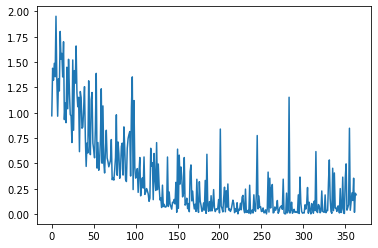

In [18]:
plt.plot(history)

In [22]:
torch.save(resnet18,"resnet18_trained_98.pt")